In [32]:
# Step 1: Install the required library
!pip install yfinance --quiet

# Step 2: Import necessary libraries
import yfinance as yf
import pandas as pd

# Step 3: Download historical stock data for Apple (AAPL)
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2024-12-31'

data = yf.download(ticker, start=start_date, end=end_date)

# Step 4: Display the first few rows
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200
2020-01-07,72.146957,72.753839,71.926930,72.497545,108872000
2020-01-08,73.307510,73.609745,71.849533,71.849533,132079200


In [39]:
# Ensure Close is a Series, not a DataFrame
close_series = data['Close']
if isinstance(close_series, pd.DataFrame):
    close_series = close_series.squeeze()  # Convert to Series

# Calculate RSI
from ta.momentum import RSIIndicator
rsi = RSIIndicator(close=close_series, window=14)
data['RSI'] = rsi.rsi()

In [42]:
# Calculate Simple Moving Average (SMA)
data['SMA_20'] = close_series.rolling(window=20).mean()
data['SMA_50'] = close_series.rolling(window=50).mean()

# Calculate Exponential Moving Average (EMA)
data['EMA_20'] = close_series.ewm(span=20, adjust=False).mean()
data['EMA_50'] = close_series.ewm(span=50, adjust=False).mean()

# Calculate Bollinger Bands
data['BB_Middle'] = data['SMA_20']
data['BB_Upper'] = data['BB_Middle'] + 2 * close_series.rolling(window=20).std()
data['BB_Lower'] = data['BB_Middle'] - 2 * close_series.rolling(window=20).std()

# Display the first few rows with the new indicators
data.head()

Price,Close,High,Low,Open,Volume,SMA_20,EMA_20,RSI,SMA_50,EMA_50,BB_Middle,BB_Upper,BB_Lower
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,
Date,,,,,,,,,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400,NaN,72.620842,NaN,NaN,72.620842,NaN,NaN,NaN
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800,NaN,72.553602,NaN,NaN,72.593155,NaN,NaN,NaN
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200,NaN,72.547339,NaN,NaN,72.589025,NaN,NaN,NaN
2020-01-07,72.146957,72.753839,71.926930,72.497545,108872000,NaN,72.509208,NaN,NaN,72.571689,NaN,NaN,NaN
2020-01-08,73.307510,73.609745,71.849533,71.849533,132079200,NaN,72.585236,NaN,NaN,72.600545,NaN,NaN,NaN


In [43]:
data = data.dropna()

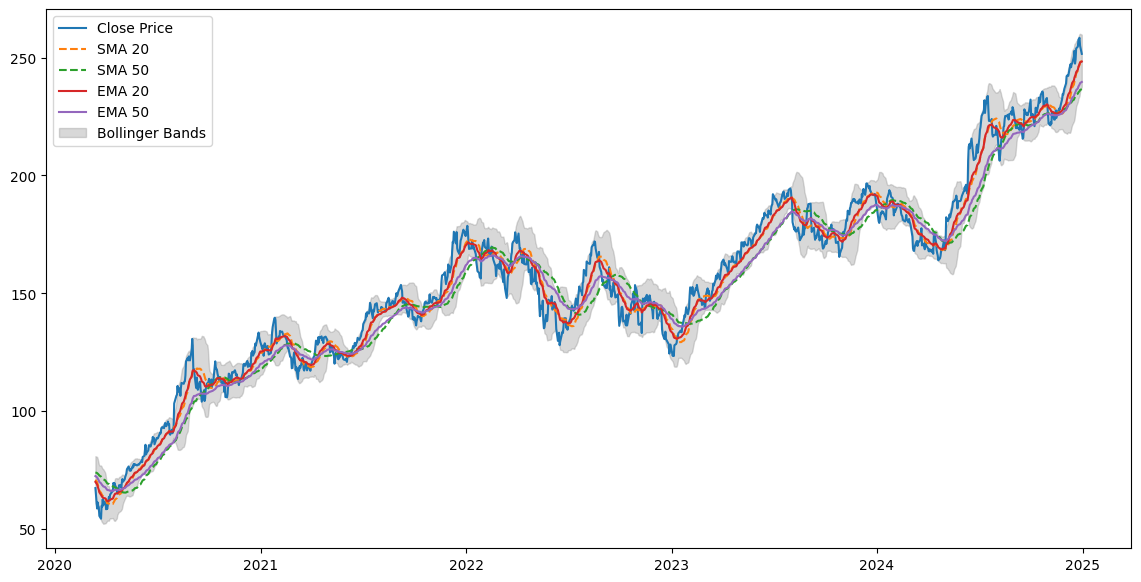

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price')
plt.plot(data.index, data['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(data.index, data['SMA_50'], label='SMA 50', linestyle='--')
plt.plot(data.index, data['EMA_20'], label='EMA 20')
plt.plot(data.index, data['EMA_50'], label='EMA 50')
plt.fill_between(data.index, data['BB_Upper'], data['BB_Lower'], color='grey', alpha=0.3, label='Bollinger Bands')
plt.legend()
plt.show()

In [45]:
from sklearn.ensemble import IsolationForest
import numpy as np

In [46]:
# Selecting features for anomaly detection
features = data[['Close', 'SMA_20', 'EMA_20', 'BB_Upper', 'BB_Lower']].copy()

# Handling any remaining NaN values
features = features.dropna()

In [47]:
# Initialize the Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Fit the model
model.fit(features)

# Predict anomalies (-1 for anomaly, 1 for normal)
data['Anomaly'] = model.predict(features)

# Map -1 to True and 1 to False for easier interpretation
data['Anomaly'] = data['Anomaly'] == -1

<ipython-input-47-4823b5d61eea>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Anomaly'] = model.predict(features)
<ipython-input-47-4823b5d61eea>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Anomaly'] = data['Anomaly'] == -1


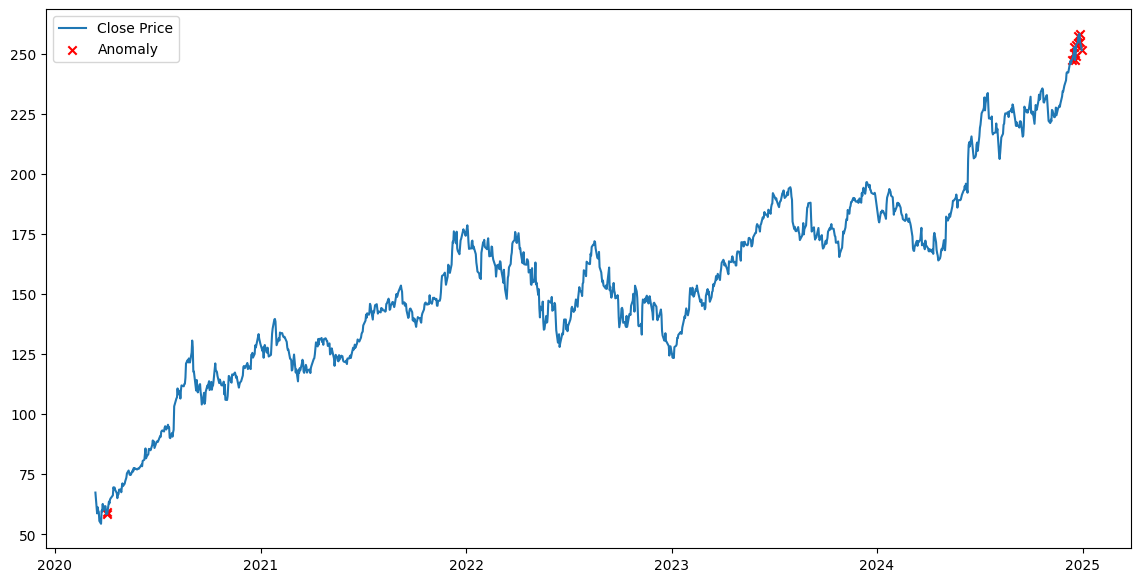

In [48]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price')
plt.scatter(data.index[data['Anomaly']], data['Close'][data['Anomaly']],
            color='red', label='Anomaly', marker='x')
plt.legend()
plt.show()

In [50]:
!pip install prophet --quiet

In [51]:
from prophet import Prophet

In [52]:
# Prepare data for Prophet
prophet_data = data[['Close']].reset_index()
prophet_data.columns = ['ds', 'y']

In [53]:
# Initialize the Prophet model
model = Prophet(daily_seasonality=True)

# Fit the model to the data
model.fit(prophet_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpy736v0tq/rafs9y52.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy736v0tq/luuwo334.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38519', 'data', 'file=/tmp/tmpy736v0tq/rafs9y52.json', 'init=/tmp/tmpy736v0tq/luuwo334.json', 'output', 'file=/tmp/tmpy736v0tq/prophet_modelze9nlh__/prophet_model-20250514140026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:00:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:00:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [54]:
# Create a DataFrame to hold the future dates
future = model.make_future_dataframe(periods=180)

# Forecast
forecast = model.predict(future)

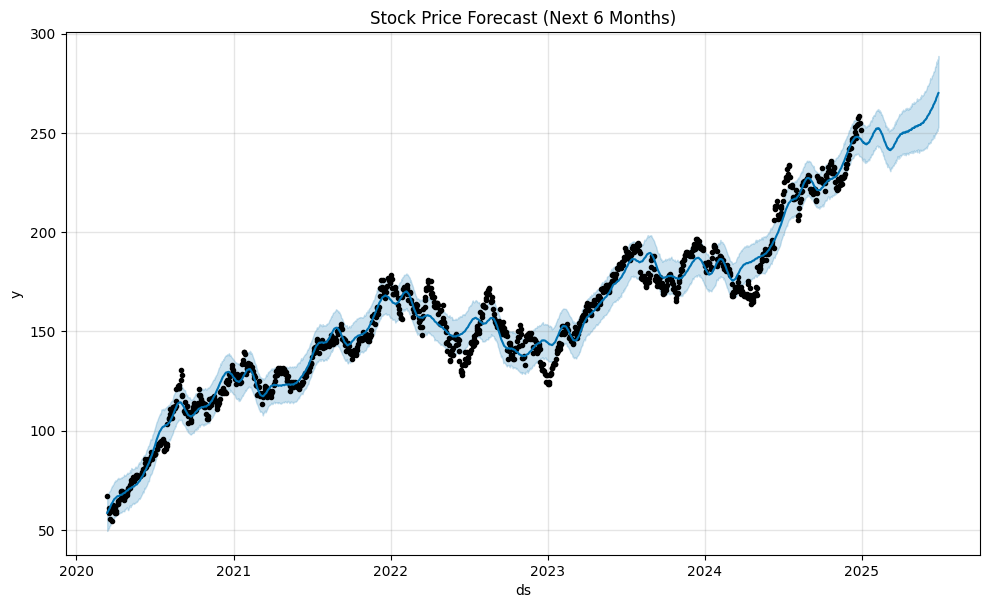

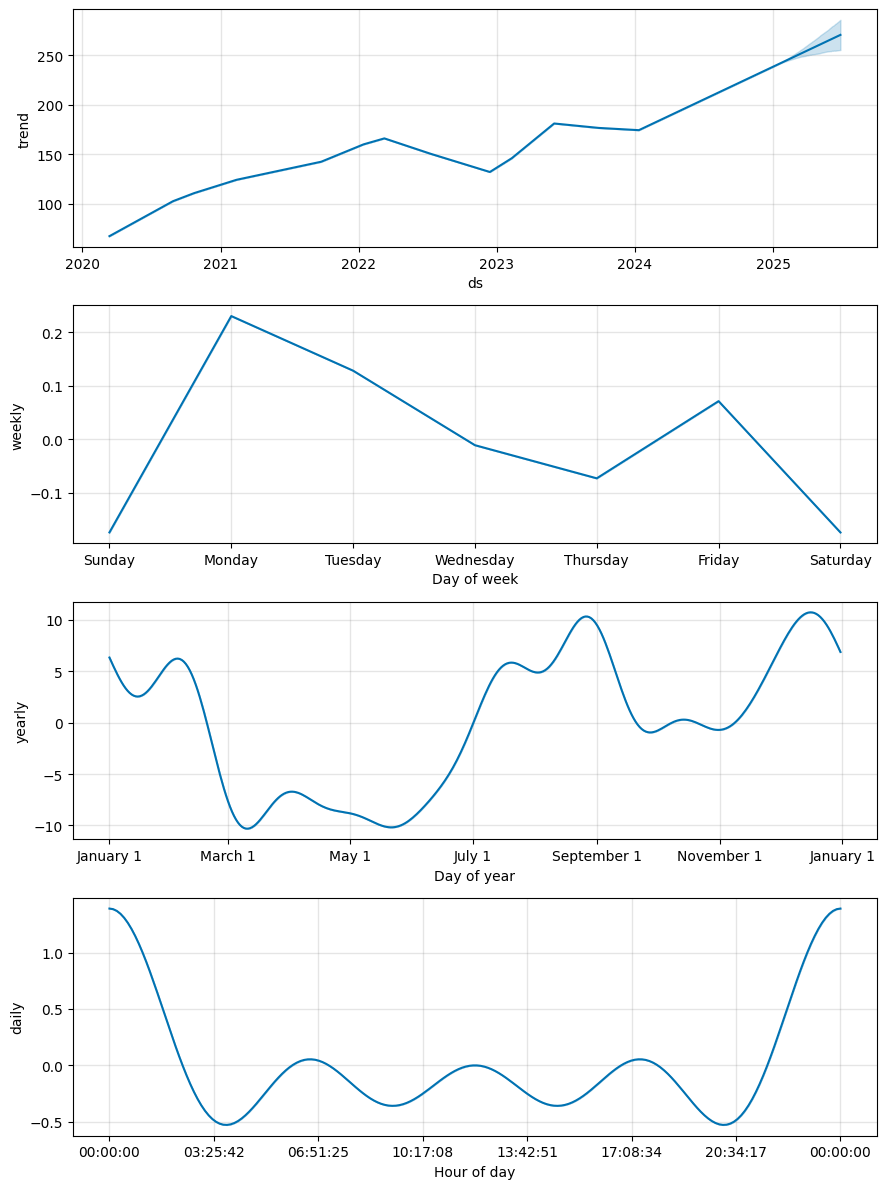

In [55]:
# Plot the forecast
fig = model.plot(forecast)
plt.title('Stock Price Forecast (Next 6 Months)')
plt.show()

# Plot components (Trend, Weekly, Yearly)
fig2 = model.plot_components(forecast)
plt.show()

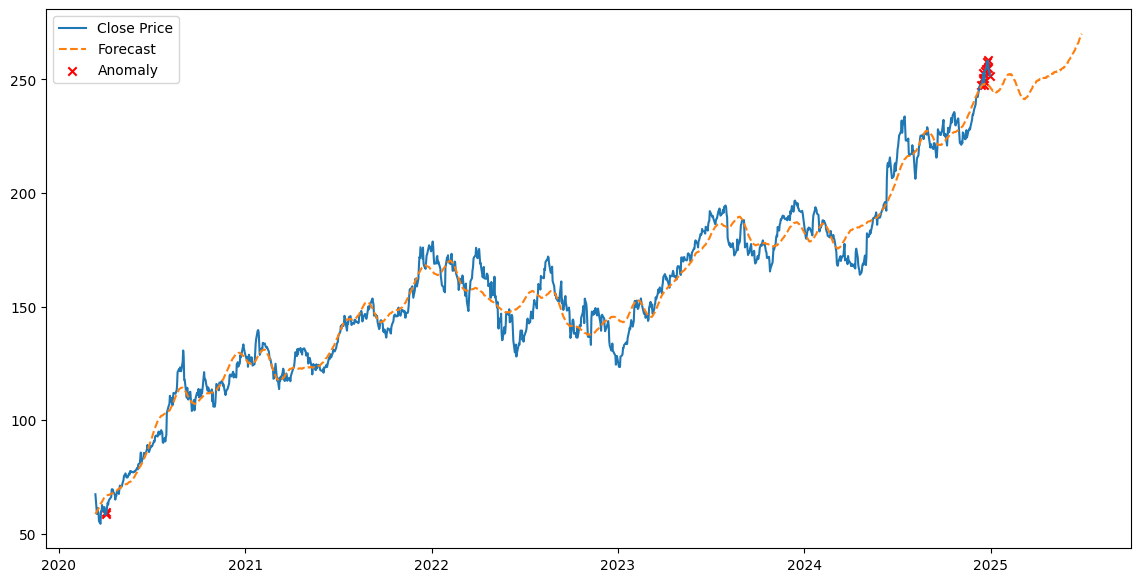

In [56]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
plt.scatter(data.index[data['Anomaly']], data['Close'][data['Anomaly']],
            color='red', label='Anomaly', marker='x')
plt.legend()
plt.show()

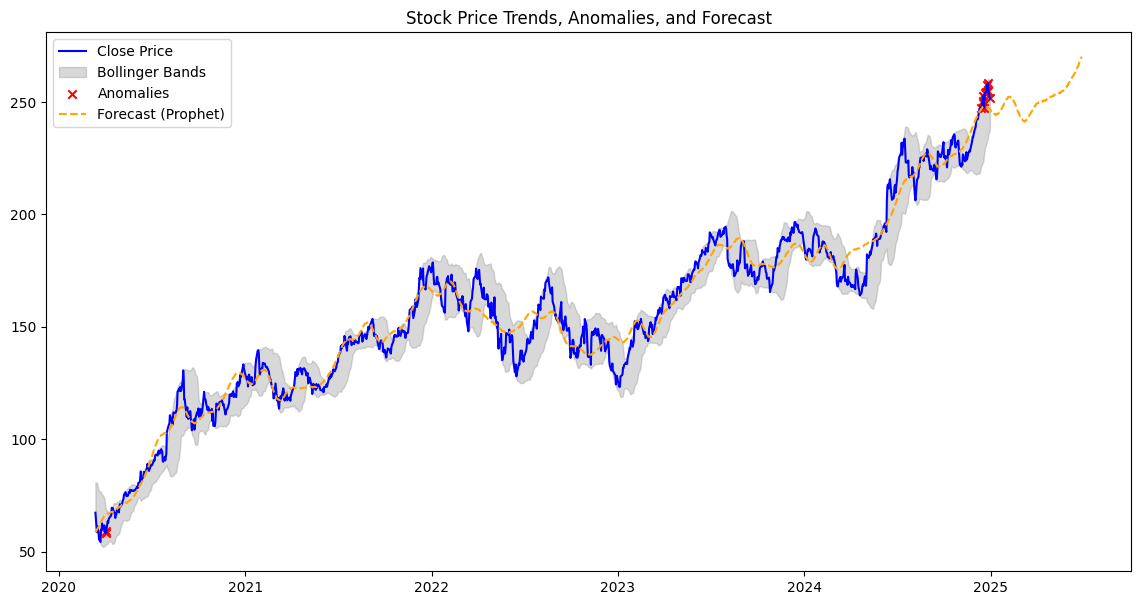

In [57]:
plt.figure(figsize=(14, 7))

# Plot historical prices
plt.plot(data.index, data['Close'], label='Close Price', color='blue')

# Plot Bollinger Bands
plt.fill_between(data.index, data['BB_Upper'], data['BB_Lower'], color='grey', alpha=0.3, label='Bollinger Bands')

# Plot Anomalies
plt.scatter(data.index[data['Anomaly']], data['Close'][data['Anomaly']],
            color='red', label='Anomalies', marker='x')

# Plot the Prophet forecast
plt.plot(forecast['ds'], forecast['yhat'], linestyle='--', color='orange', label='Forecast (Prophet)')

# Adding legends and labels
plt.title('Stock Price Trends, Anomalies, and Forecast')
plt.legend()
plt.show()

In [59]:
# Total number of anomalies
total_anomalies = data['Anomaly'].sum()
print(f"Total Anomalies Detected: {total_anomalies}")

# Date and price of the highest anomaly detected
if total_anomalies > 0:
    highest_anomaly = data[data['Anomaly']]['Close'].idxmax()
    print(f"Highest Anomaly Detected on: {highest_anomaly} with a price of {data.loc[highest_anomaly, 'Close']}")
else:
    print("No significant anomalies detected.")

# Date of the highest forecasted price
highest_forecast = forecast.loc[forecast['yhat'].idxmax()]
print(f"Highest Forecasted Price on: {highest_forecast['ds']} with a price of {highest_forecast['yhat']}")

Total Anomalies Detected: 13
Highest Anomaly Detected on: Ticker
AAPL   2024-12-26
dtype: datetime64[ns] with a price of Ticker            AAPL
Date                  
2024-12-26  258.396667
Highest Forecasted Price on: 2025-06-28 00:00:00 with a price of 270.10547517358395


This is the final report where all the results are shown.